In [1]:
import pandas as pd
import numpy as np
import researchpy as rp
import statsmodels.api as sm
import scipy.stats as stats
from patsy import dmatrices
import seaborn as sns

### Statistical Analysis

Change the folder either to `instagram_data/` or to `twitter_data/`

In [5]:
folder  = 'twitter_data/' #twitter_data/ or instagram_data/

In [6]:
data = pd.read_csv(folder +'posts_processed.csv')
green = pd.read_csv(folder +'green_posts_processed.csv')

/var/folders/pv/j2wxhdx50y5fbwqrc2yxqwf00000gn/T/ipykernel_73098/1928277876.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(folder +'posts_processed.csv')


drop unwanted columns

In [9]:
#set to data or green
whole_dataset = True
if whole_dataset:
    df = data
else:
    df = green
if "instagram" in folder:
    specific_cols = ['comments','score']
else:
    specific_cols = ['retweets', 'replies', 'quotes', 'mentioned_usernames','mentioned_hashtags','more_information_provided']
    if not whole_dataset:
        specific_cols = specific_cols + ['prediction_general']

df = df[['author', 'Branche-6', 'B2C', 'likes', 'year', 'post_text', 'green']+specific_cols]
df

,author,Branche-6,B2C,likes,year,post_text,green,retweets,replies,quotes,mentioned_usernames,mentioned_hashtags,more_information_provided
0,MercedesBenz,Automobil,True,829,2018,The Berlin State of Mind.\n\nEnjoy the true de...,False,95,7,3,[],"['MBsocialcar', 'MercedesBenz']",True
1,Porsche,Automobil,True,257,2018,It's officially #SportscarTogether day! How ar...,False,46,8,3,[],"['SportscarTogether', 'Porsche70Years']",True
2,MunichRe,Finance/Insurance,False,13,2018,With #Germany experiencing usually high temper...,True,4,1,0,[],"['Germany', 'ExtremeWeather', 'climatechange',...",True
3,MercedesBenz,Automobil,True,425,2018,The @FIAFormulaE comes to Zurich! Learn five t...,False,73,5,3,['FIAFormulaE'],"['SwitchToEQ', 'EQ', 'ABBFormulaE', 'ZurichEpr...",True
4,MercedesBenz,Automobil,True,0,2018,"RT @MercedesAMGF1: Friday, that’s a wrap... 🎬 ...",False,76,0,0,['MercedesAMGF1'],['CanadianGP'],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306126,Brenntag,Technik,False,5,2018,It's still not too late to meet the Brenntag B...,False,1,0,0,[],"['fcecosmetique', 'BrenntagBrazil']",True
306127,adidas,Textil,True,0,2018,There is a new dawn for running. See how #SOLA...,True,280,0,0,['adidasrunning'],['SOLARBOOST'],False
306128,continentaltire,Automobil,False,8,2018,Are your tires properly inflated? Now is a goo...,False,3,0,0,[],['NationalTireSafetyWeek'],True
306129,covestro,Technik,False,19,2018,In order to sustain our planet's finite resour...,True,4,0,2,[],"['InnovationForSustainableGrowth', 'UTECHEurope']",True


Transform categorical/boolean variables to numerical form for statistical analysis

In [10]:
cat_columns = df.select_dtypes(['bool']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])
df

/var/folders/pv/j2wxhdx50y5fbwqrc2yxqwf00000gn/T/ipykernel_73098/3512924057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])


,author,Branche-6,B2C,likes,year,post_text,green,retweets,replies,quotes,mentioned_usernames,mentioned_hashtags,more_information_provided
0,MercedesBenz,Automobil,0,829,2018,The Berlin State of Mind.\n\nEnjoy the true de...,0,95,7,3,[],"['MBsocialcar', 'MercedesBenz']",0
1,Porsche,Automobil,0,257,2018,It's officially #SportscarTogether day! How ar...,0,46,8,3,[],"['SportscarTogether', 'Porsche70Years']",0
2,MunichRe,Finance/Insurance,1,13,2018,With #Germany experiencing usually high temper...,1,4,1,0,[],"['Germany', 'ExtremeWeather', 'climatechange',...",0
3,MercedesBenz,Automobil,0,425,2018,The @FIAFormulaE comes to Zurich! Learn five t...,0,73,5,3,['FIAFormulaE'],"['SwitchToEQ', 'EQ', 'ABBFormulaE', 'ZurichEpr...",0
4,MercedesBenz,Automobil,0,0,2018,"RT @MercedesAMGF1: Friday, that’s a wrap... 🎬 ...",0,76,0,0,['MercedesAMGF1'],['CanadianGP'],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306126,Brenntag,Technik,1,5,2018,It's still not too late to meet the Brenntag B...,0,1,0,0,[],"['fcecosmetique', 'BrenntagBrazil']",0
306127,adidas,Textil,0,0,2018,There is a new dawn for running. See how #SOLA...,1,280,0,0,['adidasrunning'],['SOLARBOOST'],1
306128,continentaltire,Automobil,1,8,2018,Are your tires properly inflated? Now is a goo...,0,3,0,0,[],['NationalTireSafetyWeek'],0
306129,covestro,Technik,1,19,2018,In order to sustain our planet's finite resour...,1,4,0,2,[],"['InnovationForSustainableGrowth', 'UTECHEurope']",0


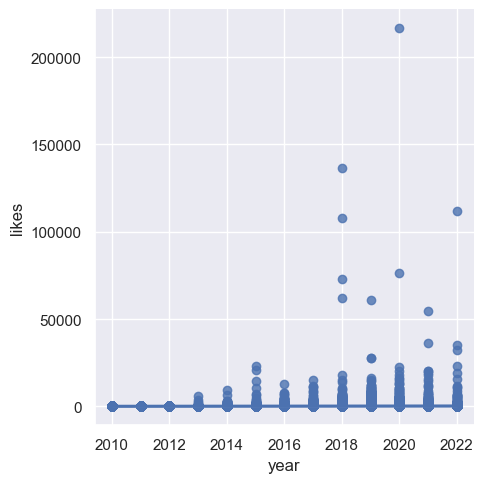

In [12]:
x_var = 'year'
y_var = 'likes'
sns.set(rc={'figure.figsize':(16,8)})
sns.lmplot(x=x_var, y=y_var, data=df)

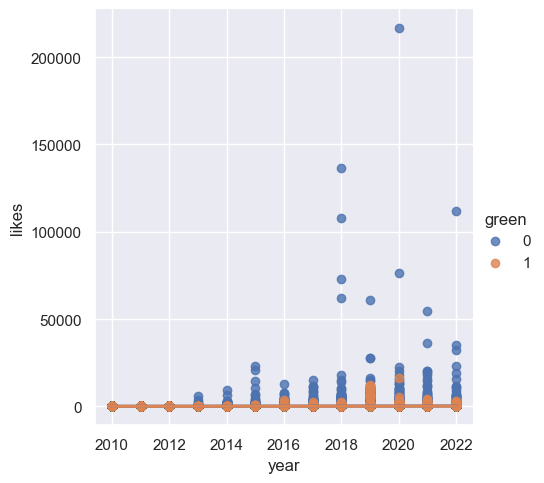

In [13]:
if whole_dataset:
    hue = 'green' 
else:
    hue = 'prediction_general'
sns.set(rc={'figure.figsize':(16,8)})
sns.lmplot(x = x_var, y=y_var, hue=hue, data=df)

Calculate correlation over whole set

In [14]:
cormat = df[list(df.select_dtypes(['int64','float64']).columns)].corr()
round(cormat,2)

,B2C,likes,year,green,retweets,replies,quotes,more_information_provided
B2C,1.00,-0.07,-0.02,0.04,-0.06,-0.05,-0.02,-0.03
likes,-0.07,1.00,0.07,-0.01,0.47,0.31,0.44,-0.04
year,-0.02,0.07,1.00,0.11,0.03,0.05,0.03,-0.12
green,0.04,-0.01,0.11,1.00,-0.01,-0.00,-0.00,0.02
retweets,-0.06,0.47,0.03,-0.01,1.00,0.12,0.21,-0.00
replies,-0.05,0.31,0.05,-0.00,0.12,1.00,0.55,-0.00
quotes,-0.02,0.44,0.03,-0.00,0.21,0.55,1.00,-0.01
more_information_provided,-0.03,-0.04,-0.12,0.02,-0.00,-0.00,-0.01,1.00


<AxesSubplot: >

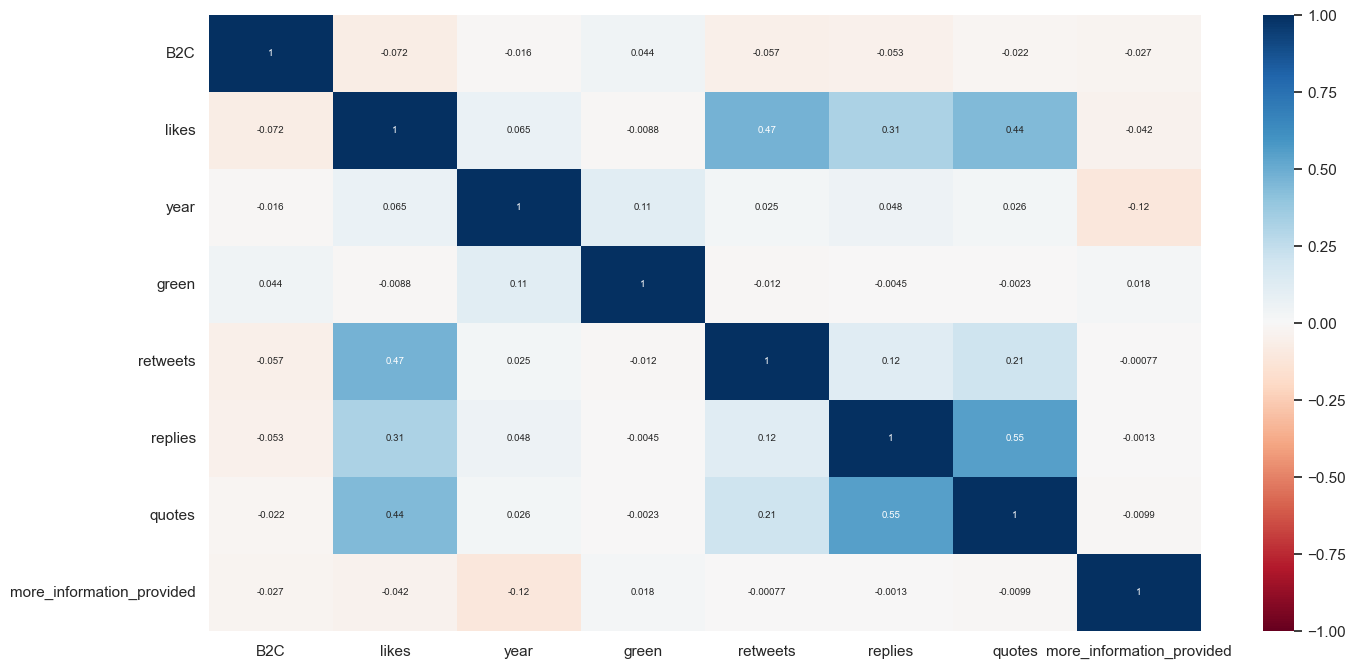

In [15]:
sns.heatmap(cormat, cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1)

Calculate per-author correlation between 2 variables (set corr_var_1 and corr_var_2) (for each author and median)

In [16]:
corr_var_1 = 'likes' #options 'likes', 'retweets', 'replies', 'quotes', 'year', 'more_information_provided', for whole datsset: 'green', for green dataset: 'prediction_general'
corr_var_2 = 'green' #same options
corr_series = df.groupby('author')[[corr_var_1,corr_var_2]].corr().unstack().iloc[:,1]
corr_series

author
Airbus             0.013944
Allianz            0.013739
BASF               0.011731
BMW                0.024975
Bayer              0.035682
Beiersdorf_AG     -0.022008
Brenntag           0.039632
DaimlerTruck       0.017383
DeutscheBank      -0.005831
DeutscheBoerse     0.036211
DeutschePostDHL    0.029130
EON_SE_en         -0.028015
FMC_AG            -0.017880
Fresenius         -0.003519
Henkel             0.077543
Infineon           0.081154
Lindeplc           0.275157
MTUaeroeng        -0.067058
MercedesBenz       0.010628
MunichRe          -0.006699
PUMA              -0.008066
Porsche           -0.010596
QIAGEN             0.012143
RWE_AG             0.130102
SAP               -0.002439
SartoriusGlobal   -0.012104
Siemens           -0.010736
SiemensHealth     -0.011877
Siemens_Energy     0.046944
SymriseAG          0.045413
VW                -0.013216
Vonovia_SE         0.020714
Zalando           -0.003216
adidas             0.007038
continentaltire   -0.021547
covestro     

In [17]:
print("Correlation between "+ corr_var_1 + " and "+ corr_var_2 + " averaged over authors: " + str(corr_series.mean()))

Correlation between likes and green averaged over authors: 0.0186696284749872


In [18]:
#options for metric: likes, for twitter: retweets, replies, quotes; for instagram: comments
metric = "likes"
groupby = ["author","green"] #replace 'green' with 'general_prediction' if dataset is green

pd.set_option('display.max_rows', None)
rp.summary_cont(df.groupby(groupby)[metric])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


N      Mean         SD        SE  95% Conf.  \
author          green                                                    
Airbus          0       7710  150.3992   362.2769    4.1259   142.3114   
                1        316  176.3703   361.2895   20.3241   136.3821   
Allianz         0       4607   11.4187   225.6101    3.3239     4.9023   
                1        773   19.9780   170.4397    6.1303     7.9440   
BASF            0       5821   10.8315    76.5825    1.0038     8.8637   
                1       1336   13.1063    70.9602    1.9414     9.2978   
BMW             0       6027  470.6959   736.5891    9.4880   452.0960   
                1        244  564.9631   533.9435   34.1822   497.6318   
Bayer           0       7246   11.3944    55.4617    0.6515    10.1172   
                1        634   18.6136    49.4335    1.9633    14.7583   
Beiersdorf_AG   0        443    7.1287    50.7621    2.4118     2.3887   
                1        112    4.6429     3.0309    0.2864     4.0753   
Brenntag        0        782    4.5141     3.9742    0.1421     4.2351   
                1         84    5.0357     3.0751    0.3355     4.3684   
DaimlerTruck    0       9258   49.6615   120.3071    1.2504    47.2105   
                1       1027   56.4362    78.9198    2.4626    51.6038   
DeutscheBank    0      13354    7.7632    46.0188    0.3982     6.9826   
                1        865    6.6682    20.8242    0.7080     5.2785   
DeutscheBoerse  0       7626    1.0708     4.2982    0.0492     0.9743   
                1        237    1.9747     3.0252    0.1965     1.5875   
DeutschePostDHL 0      10408    5.8517    41.0832    0.4027     5.0623   
                1       1150   10.3078    76.0685    2.2431     5.9067   
EON_SE_en       0       2301   42.5698   258.3196    5.3852    32.0095   
                1        667   27.1004    78.1707    3.0268    21.1573   
FMC_AG          0        668    7.2934    20.1335    0.7790     5.7639   
                1         27    5.4444    16.4512    3.1660    -1.0634   
Fresenius       0       3004    2.0083    12.9903    0.2370     1.5436   
                1         42    1.6190     2.3577    0.3638     0.8843   
Henkel          0       2505    5.4132    12.2341    0.2444     4.9339   
                1        837    7.7407    14.9591    0.5171     6.7258   
Infineon        0       5365    3.5735    10.7303    0.1465     3.2863   
                1        274    7.5693     6.1188    0.3697     6.8416   
Lindeplc        0       2729    3.9879     8.5011    0.1627     3.6688   
                1        512   11.5039    14.0006    0.6187    10.2883   
MTUaeroeng      0        304    6.2105     8.4112    0.4824     5.2612   
                1         50    4.6800     4.1179    0.5824     3.5097   
MercedesBenz    0      21242  330.4598   683.9217    4.6925   321.2621   
                1        464  380.4116   452.9263   21.0266   339.0923   
MunichRe        0      10662    5.6367   124.2584    1.2034     3.2779   
                1       1164    2.9631    47.0667    1.3795     0.2564   
PUMA            0      10201  143.5153  2309.9278   22.8706    98.6845   
                1        198    8.4848    52.4437    3.7270     1.1349   
Porsche         0       4149  243.2871   596.8751    9.2664   225.1199   
                1         61  190.5902   388.7920   49.7797    91.0159   
QIAGEN          0       3908    3.8247    33.4129    0.5345     2.7768   
                1         40    7.8750    32.9173    5.2047    -2.6525   
RWE_AG          0       4675    2.5782     7.8272    0.1145     2.3538   
                1        927    5.6775    12.5228    0.4113     4.8703   
SAP             0      26148   19.2773   235.5793    1.4569    16.4217   
                1        904   16.1305    57.9730    1.9282    12.3463   
SartoriusGlobal 0       4319   14.4163    98.1458    1.4934    11.4884   
                1         84    5.8095    26.6040    2.9027     0.0361   
Siemens         0       9531   

### Linear Model

Set the dependent and independent variabes for the Linear Model

Options for `dependent_var` and `independent_var`:
- instagram: "likes", "comments", "score", "green" ('prediction_general' if working on green dataset)
- twitter: "likes", "retweets", "quotes", "green" ('prediction_general' if working on green dataset)

In [13]:
#set according to above
dependent_var = "green"
if 'stagram' in folder:
    independent_var = ["likes", "score", "comments"] 
else:
    independent_var = ["likes", "quotes", "replies"] 
    #options: "green", "C(author)", for twitter "retweets", "quotes", "replies", "more_information_provided"

In [14]:
import statsmodels.formula.api as smf
model = smf.mixedlm(dependent_var + "~ " + (" + ").join(independent_var),
                    df,
                    groups= "author").fit()

model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: green      
No. Observations: 306131  Method:             REML       
No. Groups:       39      Scale:              0.0637     
Min. group size:  3       Log-Likelihood:     -13080.5348
Max. group size:  27052   Converged:          Yes        
Mean group size:  7849.5                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.093    0.015  6.215 0.000  0.064  0.123
likes           0.000    0.000  1.398 0.162 -0.000  0.000
quotes         -0.000    0.000 -1.017 0.309 -0.000  0.000
replies         0.000    0.000  2.241 0.025  0.000  0.000
author Var      0.009    0.008                           
=========================================================

"""

### Non-Linear Poisson Model

In [15]:
df = data[['green','author','likes']]
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))
expr = """likes ~ author + green"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Training data set length=244944
Testing data set length=61187


In [16]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  likes   No. Observations:               244944
Model:                            GLM   Df Residuals:                   244904
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5911e+07
Date:                Sat, 11 Feb 2023   Deviance:                   5.1162e+07
Time:                        16:03:26   Pearson chi2:                 9.22e+08
No. Iterations:                    25   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             